<a href="https://www.kaggle.com/code/tbillington/sql-analysis-of-us-craft-beers-breweries?scriptVersionId=162866202" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

![](https://www.oculyze.net/wp-content/uploads/2023/02/how-to-clean-beer-taps-2.jpg)

# US Craft Beers

In [1]:
import pandas as pd
import sqlite3

conn = sqlite3.connect("/kaggle/input/beer-and-breweries-db/beers.db")

In [2]:
df = pd.read_sql_query("""
SELECT name 
FROM sqlite_master 
WHERE type = 'table';
""", conn)

df

,name
0,beers
1,breweries


In [3]:
# Finding the column names and types in each table:

for table in ['beers','breweries']:
    
    df = pd.read_sql_query(f"""
    PRAGMA table_info({table});
    """, conn)
    print(df[['name','type']])
    print('='*40)

         name     type
0         abv     REAL
1         ibu     REAL
2          id  INTEGER
3        name     TEXT
4       style     TEXT
5  brewery_id  INTEGER
6      ounces     REAL
         name     type
0  brewery_id  INTEGER
1        name     TEXT
2        city     TEXT
3       state     TEXT


# Querying the tables

In [4]:
metadata_result = pd.read_sql_query("""
SELECT type, name, tbl_name, rootpage, sql
FROM sqlite_master;
""", conn)

metadata_result

,type,name,tbl_name,rootpage,sql
0,table,beers,beers,2,"CREATE TABLE ""beers"" (\n""abv"" REAL,\n ""ibu"" R..."
1,table,breweries,breweries,40,"CREATE TABLE ""breweries"" (\n""brewery_id"" INTEG..."


In [5]:
#Retrieving first 5 rows of info from 'beers': abv, ibu, name, style

five_rows_beers = pd.read_sql_query("""
SELECT abv, ibu, name, style
FROM beers
LIMIT 5;
""", conn)

five_rows_beers

,abv,ibu,name,style
0,0.050,None,Pub Beer,American Pale Lager
1,0.066,None,Devil's Cup,American Pale Ale (APA)
2,0.071,None,Rise of the Phoenix,American IPA
3,0.090,None,Sinister,American Double / Imperial IPA
4,0.075,None,Sex and Candy,American IPA


In [6]:
#Retrieving first 5 rows of info from 'breweries': brewery_id, name, city, state

five_rows_breweries = pd.read_sql_query("""
SELECT brewery_id, name, city, state
FROM breweries
LIMIT 5;
""", conn)

five_rows_breweries

,brewery_id,name,city,state
0,0,NorthGate Brewing,Minneapolis,MN
1,1,Against the Grain Brewery,Louisville,KY
2,2,Jack's Abby Craft Lagers,Framingham,MA
3,3,Mike Hess Brewing Company,San Diego,CA
4,4,Fort Point Beer Company,San Francisco,CA


In [7]:
#Using an alias 'row_count' to find out the number of rows in 'beer':

beers_total_rows = pd.read_sql_query("""
SELECT COUNT(*) AS row_count
FROM beers;
""", conn)

beers_total_rows

,row_count
0,2410


In [8]:
# Finding the number of distinct styles of beer in the 'beers' table:

distinct_styles = pd.read_sql_query("""
SELECT COUNT(DISTINCT(style)) AS distinct_styles
FROM beers;
""", conn)

distinct_styles

,distinct_styles
0,99


In [9]:
# Finding the min, average, and max abvs in the beers table:

alcoholic_content = pd.read_sql_query("""
SELECT MIN(abv) AS min, AVG(abv) AS avg, MAX(abv) AS max
FROM beers;
""", conn)

alcoholic_content

,min,avg,max
0,0.001,0.059773,0.128


In [10]:
# Getting only the abv column from the beers table:

abv_distribution = pd.read_sql_query("""
SELECT abv
FROM beers;
""", conn)

abv_distribution

,abv
0,0.050
1,0.066
2,0.071
3,0.090
4,0.075
...,...
2405,0.067
2406,0.052
2407,0.055
2408,0.055


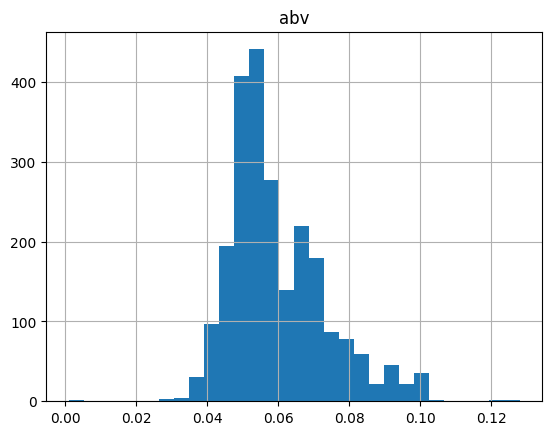

In [11]:
# Creating a histogram of the abv content

abv_hist = abv_distribution.hist(bins=30);

In [12]:
# Finding the distinct ipa styles:

ipa_styles = pd.read_sql_query("""
SELECT DISTINCT(style) AS ipa_styles
FROM beers
WHERE style LIKE "%ipa%"
ORDER BY style ASC;
""", conn)

ipa_styles

,ipa_styles
0,American Double / Imperial IPA
1,American IPA
2,American White IPA
3,Belgian IPA
4,English India Pale Ale (IPA)


The `ibu` is an abbreviation for the International Bitterness Units scale; a measurement of a beer's bitterness. Calculate the average bitterness of lager beers and pale ale beers. A beer style lager contains `"lager"`, and a beer style is pale ale if its style contains `"IPA"`, `"APA"` or `"Pale Ale"`.

In [13]:
#Finding the average iby for pale ales and lagers.

ale_bitterness = pd.read_sql_query("""
SELECT AVG(ibu)
FROM beers
WHERE style LIKE "%ipa%" OR style LIKE '%apa%' OR style LIKE '%pale ale%';
""", conn)

print(ale_bitterness)

lager_bitterness = pd.read_sql_query("""
SELECT AVG(ibu)
FROM beers
WHERE style LIKE "%lager%";
""", conn)

print(lager_bitterness)

    AVG(ibu)
0  63.353571
    AVG(ibu)
0  22.863636


In [14]:
# Calculating the number of beers there are of each style in the beers table. 

style_count = pd.read_sql_query("""
SELECT DISTINCT style, 
COUNT() OVER(PARTITION BY style) AS number
FROM beers
ORDER BY number DESC;
""", conn)

style_count

,style,number
0,American IPA,424
1,American Pale Ale (APA),245
2,American Amber / Red Ale,133
3,American Blonde Ale,108
4,American Double / Imperial IPA,105
...,...,...
95,Kristalweizen,1
96,Low Alcohol Beer,1
97,Other,1
98,Smoked Beer,1


In [15]:
# Inner joining two tables to find all the breweries and beers that can be found in San Francisco

beers_and_brewery = pd.read_sql_query("""
SELECT beers.name AS beer, breweries.name AS brewery 
FROM beers
INNER JOIN breweries
ON beers.brewery_id = breweries.brewery_id
WHERE breweries.city = 'San Francisco'
ORDER BY brewery ASC, beer ASC;
""", conn)

beers_and_brewery

,beer,brewery
0,21st Amendment IPA (2006),21st Amendment Brewery
1,21st Amendment Watermelon Wheat Beer (2006),21st Amendment Brewery
2,Back in Black,21st Amendment Brewery
3,Bitter American,21st Amendment Brewery
4,Bitter American (2011),21st Amendment Brewery
5,Brew Free! or Die IPA,21st Amendment Brewery
6,Brew Free! or Die IPA (2008),21st Amendment Brewery
7,Brew Free! or Die IPA (2009),21st Amendment Brewery
8,Fireside Chat,21st Amendment Brewery
9,Fireside Chat (2010),21st Amendment Brewery


In [16]:
# Querying both tables to find the largest breweries by number of beers produced:

largest_breweries = pd.read_sql_query("""
SELECT breweries.name AS name, COUNT(*) AS "number of beers"
FROM beers
INNER JOIN breweries
ON beers.brewery_id = breweries.brewery_id
GROUP BY breweries.brewery_id, breweries.name 
ORDER BY "number of beers" DESC, name ASC
LIMIT 10;
""", conn)

largest_breweries

,name,number of beers
0,Brewery Vivant,62
1,Sun King Brewing Company,38
2,Oskar Blues Brewery,33
3,Cigar City Brewing Company,25
4,Sixpoint Craft Ales,24
5,Hopworks Urban Brewery,23
6,Stevens Point Brewery,22
7,21st Amendment Brewery,20
8,Great Crescent Brewery,20
9,Bonfire Brewing Company,19


In [17]:
# Querying both tables to identify the top 10 US states with regard to the number of breweries:

top_10_states = pd.read_sql_query("""
SELECT
    brew.state AS state
    , COUNT(DISTINCT(brew.brewery_id)) AS breweries
    , COUNT(*) AS beers
FROM beers
JOIN breweries AS brew
ON beers.brewery_id = brew.brewery_id
GROUP BY state
ORDER BY breweries DESC, state ASC
LIMIT 10
""", conn)

top_10_states

,state,breweries,beers
0,CO,47,265
1,CA,39,183
2,MI,32,162
3,OR,29,125
4,TX,28,130
5,PA,25,100
6,MA,23,82
7,WA,23,68
8,IN,22,139
9,WI,20,87


In [18]:
# A more flexible way of processing the same request, which is more flexible

top_10_states_result_2 = pd.read_sql_query("""
    SELECT state, count(*) AS "breweries", sum(b.beers) "beers" FROM breweries
    JOIN 
        (SELECT brewery_id, count(*) AS beers
         FROM beers
         GROUP BY brewery_id) b 
    ON b.brewery_id = breweries.brewery_id
    GROUP BY state
    ORDER BY breweries DESC, state ASC
    LIMIT 10
""", conn)

top_10_states_result_2

,state,breweries,beers
0,CO,47,265
1,CA,39,183
2,MI,32,162
3,OR,29,125
4,TX,28,130
5,PA,25,100
6,MA,23,82
7,WA,23,68
8,IN,22,139
9,WI,20,87
